In [1]:
# general python modules
import sys, os, pprint, pandas
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

#sys.path.append('./')
from analysis import compute_tuning_response_per_cells
sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data, scan_folder_for_NWBfiles
sys.path.append('../')
import plot_tools as pt

folder = os.path.join(os.path.expanduser('~'), 'CURATED', 'SST-WT-NR1-GluN3-2023')

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

/home/yann.zerlaut/miniconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/yann.zerlaut/miniconda3/lib/python3.8/site-packages/skimage/morphology/_skeletonize.py:241: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  0, 1, 1, 0, 0, 1, 0, 0, 0], dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Build the dataset from the NWB files

In [ ]:
DATASET = scan_folder_for_NWBfiles(folder,
                                   verbose=False)

In [3]:
# -------------------------------------------------- #
# ----    Pick the session datafiles and sort ------ #
# ----      them according to genotype ------------- #
# -------------------------------------------------- #
# -------------------------------------------------- #
# ----    Pick the session datafiles and sort ------ #
# ----      them according to genotype ------------- #
# -------------------------------------------------- #

def init_summary(DATASET):

    SUMMARY = {'WT':{'FILES':[], 'subjects':[]}, 
               'GluN1':{'FILES':[], 'subjects':[]}, 
               'GluN3':{'FILES':[], 'subjects':[]},
               # add a summary for half contrast
               'WT_c=0.5':{'FILES':[]},
               'GluN1_c=0.5':{'FILES':[]},
               'GluN3_c=0.5':{'FILES':[]}}

    for i, protocols in enumerate(DATASET['protocols']):

        # select the sessions with different 
        if ('ff-gratings-8orientation-2contrasts-15repeats' in protocols) or\
            ('ff-gratings-8orientation-2contrasts-10repeats' in protocols):

            # sort the sessions according to the mouse genotype
            if ('NR1' in DATASET['subjects'][i]) or ('GluN1' in DATASET['subjects'][i]):
                SUMMARY['GluN1']['FILES'].append(DATASET['files'][i])
                SUMMARY['GluN1']['subjects'].append(DATASET['subjects'][i])
            elif ('NR3' in DATASET['subjects'][i]) or ('GluN3' in DATASET['subjects'][i]):
                SUMMARY['GluN3']['FILES'].append(DATASET['files'][i])
                SUMMARY['GluN3']['subjects'].append(DATASET['subjects'][i])
            else:
                SUMMARY['WT']['FILES'].append(DATASET['files'][i])
                SUMMARY['WT']['subjects'].append(DATASET['subjects'][i])
                
    return SUMMARY

In [4]:
SUMMARY

NameError: name 'SUMMARY' is not defined

## Analysis

In [4]:
# -------------------------------------------------- #
# ----   Loop over datafiles to compute    --------- #
# ----           the evoked responses      --------- #
# -------------------------------------------------- #

def orientation_selectivity_index(resp_pref, resp_90):
    """                                                                         
     computes the selectivity index: (Pref-Orth)/Pref
     clipped in [0,1] --> because resp_90 can be negative    
    """
    return (resp_pref-np.clip(resp_90, 0, np.inf))/resp_pref

stat_test_props = dict(interval_pre=[-1.,0],                                   
                       interval_post=[1.,2.],                                   
                       test='ttest',                                            
                       positive=True) 
    
def compute_summary_responses(DATASET,
                              quantity='dFoF',
                              roi_to_neuropil_fluo_inclusion_factor=1.15,
                              neuropil_correction_factor = 0.7,
                              method_for_F0 = 'sliding_percentile',
                              percentile=5., # percent
                              sliding_window = 300, # seconds
                              Nmax=999, # max datafiles (for debugging)
                              stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                   interval_post=[1.,2.],                                   
                                                   test='anova',                                            
                                                   positive=True),
                              response_significance_threshold=5e-2,
                              verbose=True):
    
    SUMMARY = init_summary(DATASET)
    
    SUMMARY['quantity'] = quantity
    SUMMARY['quantity_args'] = dict(roi_to_neuropil_fluo_inclusion_factor=\
                                        roi_to_neuropil_fluo_inclusion_factor,
                                    method_for_F0=method_for_F0,
                                    percentile=percentile,
                                    sliding_window=sliding_window,
                                    neuropil_correction_factor=neuropil_correction_factor)
    
    for key in ['WT', 'GluN1', 'GluN3']:

        SUMMARY[key]['RESPONSES'], SUMMARY[key]['OSI'], SUMMARY[key]['FRAC_RESP'] = [], [], []
        SUMMARY[key+'_c=0.5']['RESPONSES'], SUMMARY[key+'_c=0.5']['OSI'], SUMMARY[key+'_c=0.5']['FRAC_RESP'] = [], [], []

        for f in SUMMARY[key]['FILES'][:Nmax]:

            data = Data(f, verbose=False)
            
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)

            if quantity=='dFoF':
                data.build_dFoF(roi_to_neuropil_fluo_inclusion_factor=\
                                        roi_to_neuropil_fluo_inclusion_factor,
                                method_for_F0=method_for_F0,
                                percentile=percentile,
                                sliding_window=sliding_window,
                                neuropil_correction_factor=neuropil_correction_factor,
                                verbose=False)
                
            elif quantity=='rawFluo':
                data.build_rawFluo(verbose=verbose)
            elif quantity=='neuropil':
                data.build_neuropil(verbose=verbose)            
            else:
                print('quantity not recognized !!')
            
            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            # at full contrast
            responses, frac_resp, shifted_angle = compute_tuning_response_per_cells(data,
                                                                                    imaging_quantity=quantity,
                                                                                    contrast=1,
                                                                                    protocol_name=protocol,
                                                                                    stat_test_props=stat_test_props,
                                                                                    response_significance_threshold=response_significance_threshold,
                                                                                    verbose=False)
            
            SUMMARY[key]['RESPONSES'].append(responses)
            SUMMARY[key]['OSI'].append([orientation_selectivity_index(r[1], r[5]) for r in responses])
            SUMMARY[key]['FRAC_RESP'].append(frac_resp)

            # for those two genotypes (not run for the GluN3-KO), we add:
            if key in ['WT', 'GluN1']:
                # at half contrast
                responses, frac_resp, shifted_angle = compute_tuning_response_per_cells(data,
                                                                                        contrast=0.5,
                                                                                        protocol_name=protocol,
                                                                                        stat_test_props=stat_test_props,
                                                                                        response_significance_threshold=response_significance_threshold,
                                                                                        verbose=False)
                
                SUMMARY[key+'_c=0.5']['RESPONSES'].append(responses)
                SUMMARY[key+'_c=0.5']['OSI'].append([orientation_selectivity_index(r[1], r[5]) for r in responses])
                SUMMARY[key+'_c=0.5']['FRAC_RESP'].append(frac_resp)
                
    SUMMARY['shifted_angle'] = shifted_angle
    
    return SUMMARY

## Varying the preprocessing parameters

In [ ]:
for quantity in ['rawFluo', 'neuropil', 'dFoF']:
    SUMMARY = compute_summary_responses(DATASET, quantity=quantity, verbose=False)
    np.save('../data/in-vivo/%s-ff-gratings.npy' % quantity, SUMMARY)
    
for neuropil_correction_factor in [0.6, 0.7, 0.8, 0.9]:
    SUMMARY = compute_summary_responses(DATASET, quantity='dFoF', 
                                   neuropil_correction_factor=neuropil_correction_factor,
                                   verbose=False)
    np.save('../data/in-vivo/factor-neuropil-%.1f-ff-gratings.npy' % neuropil_correction_factor, SUMMARY)
    
for roi_to_neuropil_fluo_inclusion_factor in [1.05, 1.1, 1.15, 1.2, 1.25, 1.3]:
    SUMMARY = compute_summary_responses(DATASET, 
                                   quantity='dFoF', 
                                   roi_to_neuropil_fluo_inclusion_factor=roi_to_neuropil_fluo_inclusion_factor,
                                   verbose=False)
    np.save('../data/in-vivo/inclusion-factor-neuropil-%.1f-ff-gratings.npy' % roi_to_neuropil_fluo_inclusion_factor, SUMMARY)

## Quantification & Data visualization

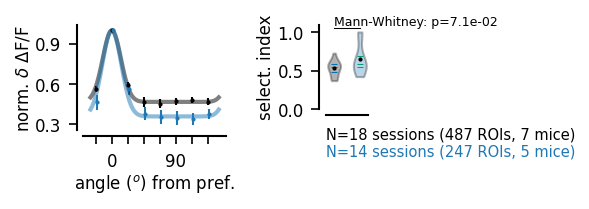

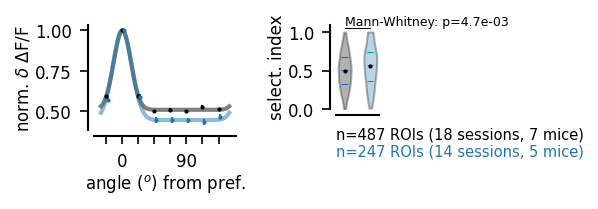

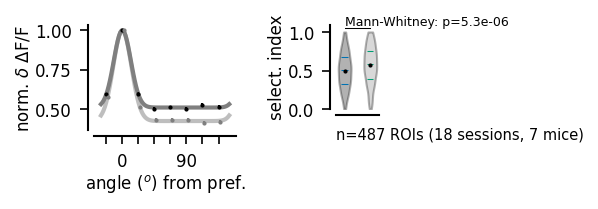

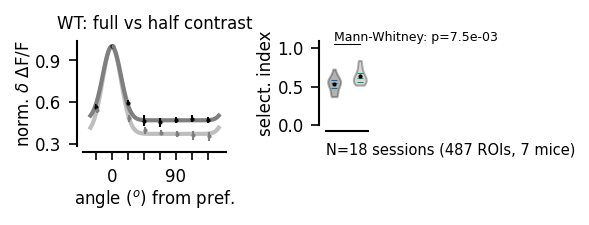

In [3]:
from scipy.optimize import minimize

def func(S, X):
    """ fitting function """
    nS = (S+90)%180-90
    return X[0]*np.exp(-(nS**2/2./X[1]**2))+X[2]

def selectivity_index(resp1, resp2):
    return (resp1-np.clip(resp2, 0, np.inf))/resp1

def generate_comparison_figs(SUMMARY, 
                             cases=['WT'],
                             average_by='ROIs',
                             colors=['k', 'tab:blue', 'tab:green'],
                             norm='',
                             ms=1):
    
    fig, ax = plt.subplots(1, figsize=(2, 1))
    plt.subplots_adjust(top=0.9, bottom=0.2, right=0.6)
    inset = pt.inset(ax, (1.7, 0.2, 0.3, 0.8))

    SIs = []
    for i, key in enumerate(cases):

        if average_by=='sessions':
            resp = np.array([np.mean(r, axis=0) for r in SUMMARY[key]['RESPONSES']])
        else:
            resp = np.concatenate([r for r in SUMMARY[key]['RESPONSES']])
        resp = np.clip(resp, 0, np.inf) # CLIP RESPONSIVE TO POSITIVE VALUES
        
        if norm!='':
            resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
            
        SIs.append([selectivity_index(r[1], r[5]) for r in resp])

        # data
        pt.scatter(SUMMARY['shifted_angle']+2*i, np.mean(resp, axis=0),
                   sy=stats.sem(resp, axis=0), ax=ax, color=colors[i], ms=ms)
        
        # fit
        def to_minimize(x0):
            return np.sum((resp.mean(axis=0)-\
                           func(SUMMARY['shifted_angle'], x0))**2)
        
        res = minimize(to_minimize,
                       [0.8, 10, 0.2])
        x = np.linspace(-30, 180-30, 100)
        ax.plot(x, func(x, res.x), lw=2, alpha=.5, color=colors[i])

        try:
            if average_by=='sessions':
                inset.annotate(i*'\n'+'\nN=%i %s (%i ROIs, %i mice)' % (len(resp),
                                                    average_by, np.sum([len(r) for r in SUMMARY[key]['RESPONSES']]),
                                                    len(np.unique(SUMMARY[key]['subjects']))),
                               (0,0), fontsize=7,
                               va='top',color=colors[i], xycoords='axes fraction')
            else:
                inset.annotate(i*'\n'+'\nn=%i %s (%i sessions, %i mice)' % (len(resp),
                                                    average_by, len(SUMMARY[key]['RESPONSES']),
                                                                    len(np.unique(SUMMARY[key]['subjects']))),
                               (0,0), fontsize=7,
                               va='top',color=colors[i], xycoords='axes fraction')
        except BaseException as be:
            pass
            
        
    # selectivity index
    for i, key in enumerate(cases):
        pt.violin(SIs[i], X=[i], ax=inset, COLORS=[colors[i]])
    if len(cases)==2:
        inset.plot([0,1], 1.05*np.ones(2), 'k-', lw=0.5)
        inset.annotate('Mann-Whitney: p=%.1e' % stats.mannwhitneyu(SIs[0], SIs[1]).pvalue,
                       (0, 1.09), fontsize=6)
    pt.set_plot(inset, xticks=[], ylabel='select. index', yticks=[0, 0.5, 1], ylim=[0, 1.09])

    ylabel=norm+'$\delta$ %s' % SUMMARY['quantity'].replace('dFoF', '$\Delta$F/F')
    pt.set_plot(ax, xlabel='angle ($^o$) from pref.',
                ylabel=ylabel,
                #yticks=[0.4,0.6,0.8,1],
                xticks=SUMMARY['shifted_angle'],
                xticks_labels=['%.0f'%s if (i%4==1) else '' for i,s in enumerate(SUMMARY['shifted_angle'])])

    return fig, ax

SUMMARY = np.load('../data/dFoF-ff-gratings.npy', allow_pickle=True).item()
fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'], average_by='sessions', norm='norm. ')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))
fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'], average_by='ROIs', norm='norm. ')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '2.svg'))
fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'WT_c=0.5'], average_by='ROIs', norm='norm. ',
                                   colors=['k', 'tab:grey'])
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '3.svg'))
fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'WT_c=0.5'], average_by='sessions', norm='norm. ',
                                   colors=['k', 'tab:grey'])
ax.set_title('WT: full vs half contrast')
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '4.svg'))

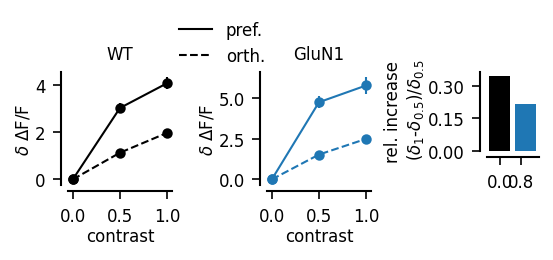

In [75]:
fig, AX = plt.subplots(1, 2, figsize=(3,1))
plt.subplots_adjust(wspace=0.9, right=0.8)
inset = pt.inset(AX[1], [2.1, 0.3, 0.5, 0.7])
for k, key, c, ax in zip(range(2), ['WT', 'GluN1'], ['k', 'tab:blue'], AX):
    resp_c05 = np.concatenate([r for r in SUMMARY[key+'_c=0.5']['RESPONSES']])
    resp_c1 = np.concatenate([r for r in SUMMARY[key]['RESPONSES']])
    for index in [1,5]:
        x, y = [0 ,0.5, 1], [0,np.mean(resp_c05[:, index]), np.mean(resp_c1[:, index])]
        sy = [0,stats.sem(resp_c05[:, index]),stats.sem(resp_c1[:, index])]
        ax.plot(x, y, '-' if index==1 else '--', color=c, label='pref.' if index==1 else 'orth.')
        pt.scatter(x, y, sy=sy, ax=ax, color=c)
        if index==1:
            rel_increase = (np.mean(resp_c1[:,index])-np.mean(resp_c05[:,index]))/np.mean(resp_c05[:,index])
            inset.bar([k], [np.mean(rel_increase)], color=c, alpha=1/index)
    pt.set_plot(ax, xlabel='contrast', title=key, xticks=[0,0.5,1], ylabel='$\delta$ $\Delta$F/F')
pt.set_plot(inset, ylabel='rel. increase\n ($\delta_{1}$-$\delta_{0.5}$)/$\delta_{0.5}$')
AX[0].legend(frameon=False, loc=(1,1))

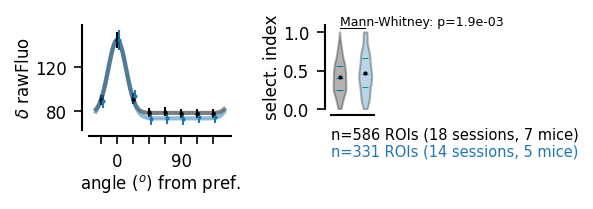

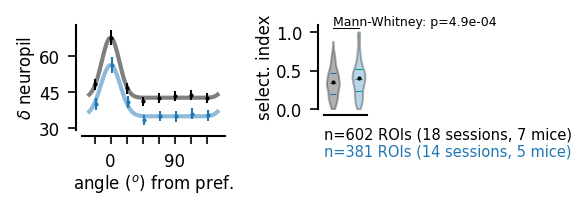

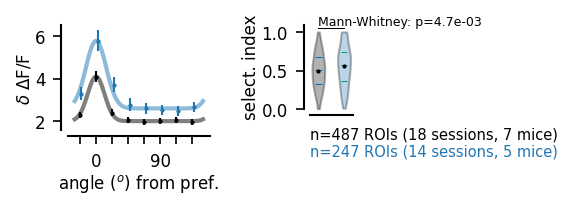

In [77]:
for quantity in ['rawFluo', 'neuropil', 'dFoF']:
    SUMMARY = np.load('../data/%s-ff-gratings.npy' % quantity, allow_pickle=True).item()
    _ = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'])

In [ ]:
for neuropil_correction_factor in [0.6, 0.7, 0.8, 0.9, 1.]:
    try:
        SUMMARY = np.load('data/factor-neuropil-%.1f-ff-gratings.npy' % neuropil_correction_factor,
                          allow_pickle=True).item()
        fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'], norm='norm. ')    
        ax.set_title('Neuropil-factor\nfor substraction: %.1f' % neuropil_correction_factor)
    except BaseException as be:
        pass

In [ ]:
for roi_to_neuropil_fluo_inclusion_factor in [1.05, 1.1, 1.15, 1.2, 1.25, 1.3]:
    SUMMARY = np.load('data/inclusion-factor-neuropil-%.1f-ff-gratings.npy' % roi_to_neuropil_fluo_inclusion_factor,
                      allow_pickle=True).item()
    fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'], norm='norm. ')    
    ax.set_title('Roi/Neuropil\ninclusion-factor: %.2f' % roi_to_neuropil_fluo_inclusion_factor)

In [ ]:
fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'WT_c=0.5'],
                                   colors=['k', 'grey'], norm='norm. ')
ax.set_title('WT: full vs half contrast');

In [ ]:
fig, ax = generate_comparison_figs(SUMMARY, ['GluN1', 'GluN1_c=0.5'],
                                colors=['tab:blue', 'tab:cyan'], norm='norm. ')
ax.set_title('GluN1: full vs half contrast');

## Testing different "visual-responsiveness" criteria

In [ ]:
# most permissive
SUMMARY = compute_summary_responses(stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                         interval_post=[1.,2.],                                   
                                                         test='ttest',                                            
                                                         positive=True),
                                    response_significance_threshold=5e-2)
FIGS = generate_comparison_figs(SUMMARY, 'WT', 'GluN1',
                                color1='k', color2='tab:blue')

In [ ]:
# most strict
SUMMARY = compute_summary_responses(stat_test_props=dict(interval_pre=[-1.5,0],                                   
                                                         interval_post=[1.,2.5],                                   
                                                         test='anova',                                            
                                                         positive=True),
                                    response_significance_threshold=1e-3)
FIGS = generate_comparison_figs(SUMMARY, 'WT', 'GluN1',
                                color1='k', color2='tab:blue')

# Visualizing some evoked response in single ROI

NWB-file reading time: 143.6ms
  Number of episodes over the whole recording: 114/163 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "maximin" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
0.1432391503683066
0.1432391503683066
0.1432391503683066
0.1432391503683066
  -> [ok] episodes ready !


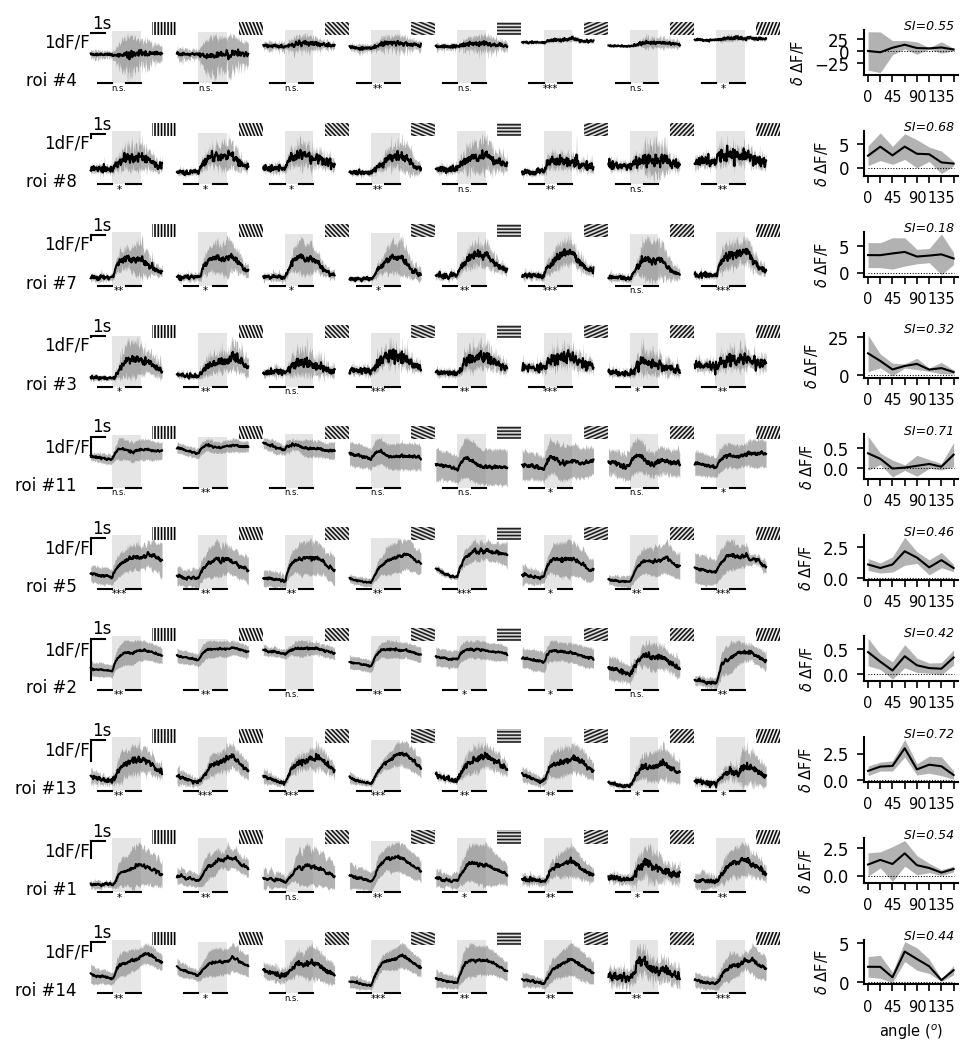

In [41]:
import sys, os
import numpy as np
import matplotlib.pylab as plt
sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data, scan_folder_for_NWBfiles
from physion.analysis.process_NWB import EpisodeData
from physion.utils import plot_tools as pt
from physion.dataviz.episodes.trial_average import plot_trial_average
sys.path.append('../')
import plot_tools as pt

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

def selectivity_index(angles, resp):
    """
    computes the selectivity index: (Pref-Orth)/(Pref+Orth)
    clipped in [0,1]
    """
    imax = np.argmax(resp)
    iop = np.argmin(((angles[imax]+90)%(180)-angles)**2)
    if (resp[imax]>0):
        return min([1,max([0,(resp[imax]-resp[iop])/(resp[imax]+resp[iop])])])
    else:
        return 0

def cell_tuning_example_fig(filename,
                            contrast=1.0,
                            stat_test_props = dict(interval_pre=[-1,0], 
                                                   interval_post=[1,2],
                                                   test='ttest',
                                                   positive=True),
                            response_significance_threshold = 0.01,
                            Nsamples = 10, # how many cells we show
                            seed=10):
    
    np.random.seed(seed)
    
    data = Data(filename)
    
    EPISODES = EpisodeData(data,
                           quantities=['dFoF'],
                           protocol_id=np.flatnonzero(['8orientation' in p for p in data.protocols]),
                           with_visual_stim=True,
                           verbose=True)
    
    fig, AX = pt.plt.subplots(Nsamples, len(EPISODES.varied_parameters['angle']), 
                          figsize=(7,7))
    plt.subplots_adjust(right=0.75, left=0.1, top=0.97, bottom=0.05, wspace=0.1, hspace=0.8)
    
    for Ax in AX:
        for ax in Ax:
            ax.axis('off')

    for i, r in enumerate(np.random.choice(np.arange(data.vNrois), 
                                           min([Nsamples, data.vNrois]), replace=False)):

        # SHOW trial-average
        plot_trial_average(EPISODES,
                           condition=(EPISODES.contrast==contrast),
                           column_key='angle',
                           #color_key='contrast',
                           #color=['lightgrey', 'k'],
                           quantity='dFoF',
                           ybar=1., ybarlabel='1dF/F',
                           xbar=1., xbarlabel='1s',
                           roiIndex=r,
                           with_stat_test=True,
                           stat_test_props=stat_test_props,
                           with_screen_inset=True,
                           AX=[AX[i]], no_set=False)
        AX[i][0].annotate('roi #%i  ' % (r+1), (0,0), ha='right', xycoords='axes fraction')

        # SHOW summary angle dependence
        inset = pt.inset(AX[i][-1], (2.2, 0.2, 1.2, 0.8))

        angles, y, sy, responsive_angles = [], [], [], []
        responsive = False

        for a, angle in enumerate(EPISODES.varied_parameters['angle']):

            stats = EPISODES.stat_test_for_evoked_responses(episode_cond=\
                                            EPISODES.find_episode_cond(key=['angle', 'contrast'],
                                                                       value=[angle, contrast]),
                                                            response_args=dict(quantity='dFoF', roiIndex=r),
                                                            **stat_test_props)

            angles.append(angle)
            y.append(np.mean(stats.y-stats.x))    # means "post-pre"
            sy.append(np.std(stats.y-stats.x))    # std "post-pre"

            if stats.significant(threshold=response_significance_threshold):
                responsive = True
                responsive_angles.append(angle)

        pt.plot(angles, np.array(y), sy=np.array(sy), ax=inset)
        inset.plot(angles, 0*np.array(angles), 'k:', lw=0.5)
        inset.set_ylabel('$\delta$ $\Delta$F/F     ', fontsize=7)
        inset.set_xticks(angles)
        inset.set_xticklabels(['%i'%a if (i%2==0) else '' for i, a in enumerate(angles)], fontsize=7)
        if i==(Nsamples-1):
            inset.set_xlabel('angle ($^{o}$)', fontsize=7)

        SI = selectivity_index(angles, y)
        inset.annotate('SI=%.2f ' % SI, (1, 1), ha='right', style='italic', fontsize=6,
                       color=('k' if responsive else 'lightgray'), xycoords='axes fraction')
        
    return fig

folder = os.path.join(os.path.expanduser('~'), 'CURATED','SST-WT-NR1-GluN3-2023')
fig = cell_tuning_example_fig(os.path.join(folder, '2023_02_15-13-30-47.nwb'),
                             contrast=1, seed=21)
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))

NWB-file reading time: 156.9ms
  Number of episodes over the whole recording: 160/163 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "maximin" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
0.1432391503683066
0.1432391503683066
0.1432391503683066
0.1432391503683066
  -> [ok] episodes ready !


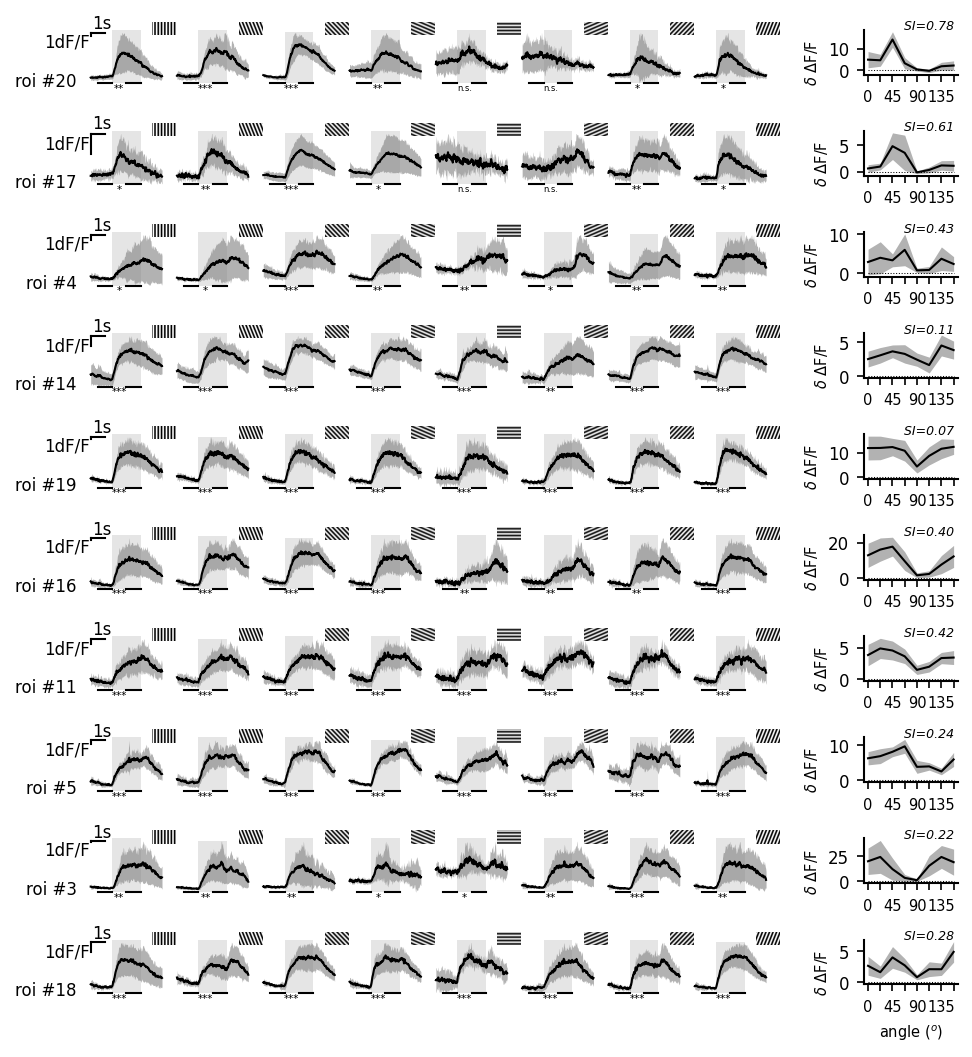

In [45]:
fig = cell_tuning_example_fig(SUMMARY['GluN1']['FILES'][2], seed=3)
#fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))

# Visualizing some raw population data

0.1432391503683066
0.1432391503683066
0.1432391503683066
0.1432391503683066
NWB-file reading time: 204.3ms
0.1432391503683066
0.1432391503683066
0.1432391503683066
0.1432391503683066

calculating dF/F with method "maximin" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)


(<Figure size 1500x600 with 2 Axes>, <AxesSubplot:>)

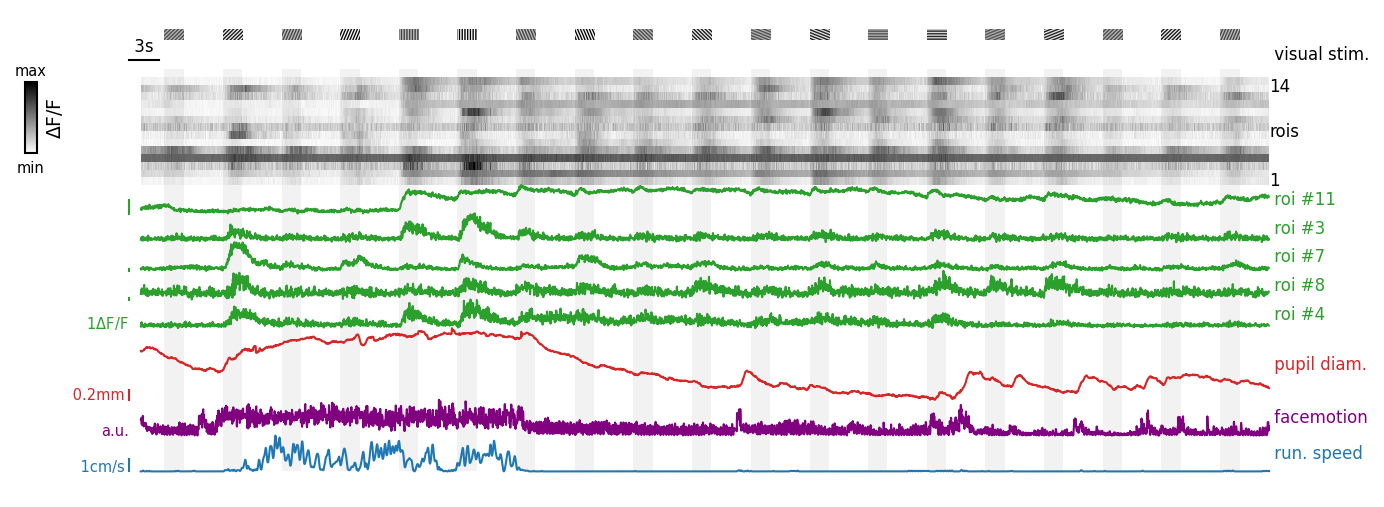

In [10]:
import sys, os
import numpy as np
import matplotlib.pylab as plt
sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data
from physion.analysis.process_NWB import EpisodeData
from physion.utils import plot_tools as pt
from physion.dataviz.raw import plot as plot_raw, find_default_plot_settings

sys.path.append('../')
import plot_tools as pt

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

data = Data(os.path.join(folder, '2023_02_15-13-30-47.nwb'),
            with_visual_stim=True)
data.init_visual_stim()

tlim = [984,1100]

settings = {'Locomotion': {'fig_fraction': 1, 'subsampling': 1, 'color': '#1f77b4'},
            'FaceMotion': {'fig_fraction': 1, 'subsampling': 1, 'color': 'purple'},
            'Pupil': {'fig_fraction': 2, 'subsampling': 1, 'color': '#d62728'},
             'CaImaging': {'fig_fraction': 4,
              'subsampling': 1,
              'subquantity': 'dF/F',
              'color': '#2ca02c',
              'roiIndices': np.random.choice(np.arange(data.nROIs), 5, replace=False)},
             'CaImagingRaster': {'fig_fraction': 3,
              'subsampling': 1,
              'roiIndices': 'all',
              'normalization': 'per-line',
              'subquantity': 'dF/F'},
             'VisualStim': {'fig_fraction': 0.5, 'color': 'black', 'with_screen_inset':True}}

plot_raw(data, tlim=tlim, settings=settings)

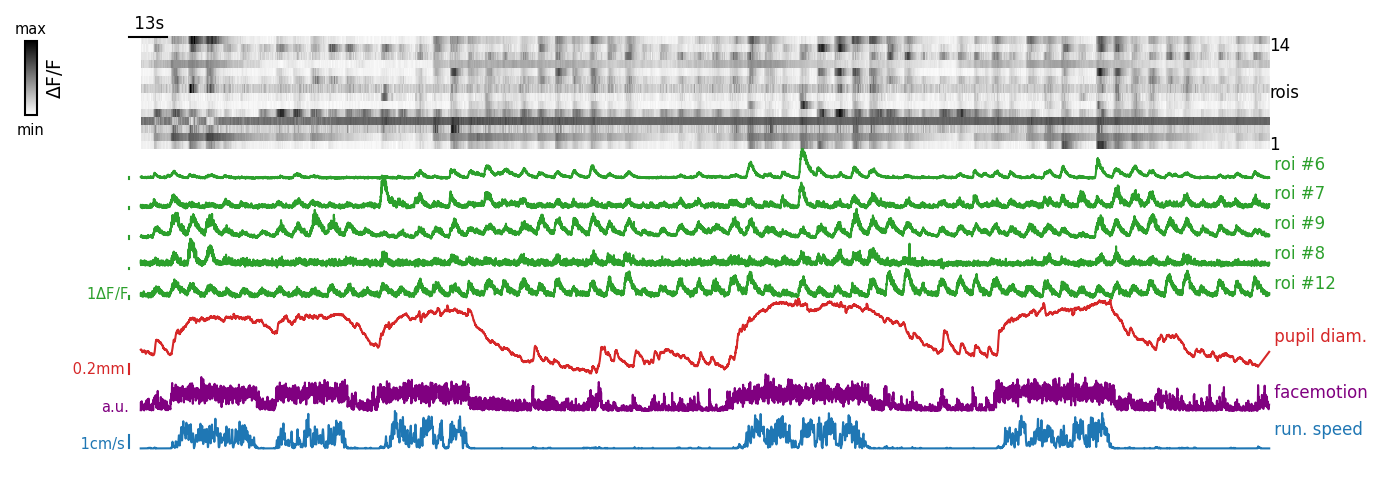

In [14]:
settings = {'Locomotion': {'fig_fraction': 1, 'subsampling': 2, 'color': '#1f77b4'},
            'FaceMotion': {'fig_fraction': 1, 'subsampling': 2, 'color': 'purple'},
            'Pupil': {'fig_fraction': 2, 'subsampling': 1, 'color': '#d62728'},
             'CaImaging': {'fig_fraction': 4,
              'subsampling': 1,
              'subquantity': 'dF/F',
              'color': '#2ca02c',
              'roiIndices': np.random.choice(np.arange(data.nROIs), 5, replace=False)},
             'CaImagingRaster': {'fig_fraction': 3,
              'subsampling': 1,
              'roiIndices': 'all',
              'normalization': 'per-line',
              'subquantity': 'dF/F'}}

tlim = [910, 1300]
fig, _ = plot_raw(data, tlim=tlim, settings=settings)
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg'))

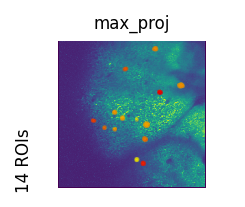

In [19]:
from physion.dataviz.imaging import show_CaImaging_FOV
fig, _, _ = show_CaImaging_FOV(data, key='max_proj', NL=3, roiIndices='all')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'fig.svg'))

(<Figure size 255x195 with 1 Axes>,
 <AxesSubplot:title={'center':'max_proj'}>,
 <matplotlib.image.AxesImage at 0x7fdbedaa43d0>)

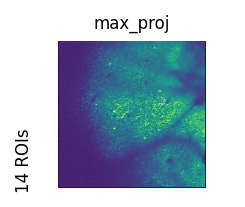

In [16]:
show_CaImaging_FOV(data, key='max_proj', NL=3)

NWB-file reading time: 157.1ms
  Number of episodes over the whole recording: 240/240 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "maximin" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
0.1432391503683066
  -> [ok] episodes ready !


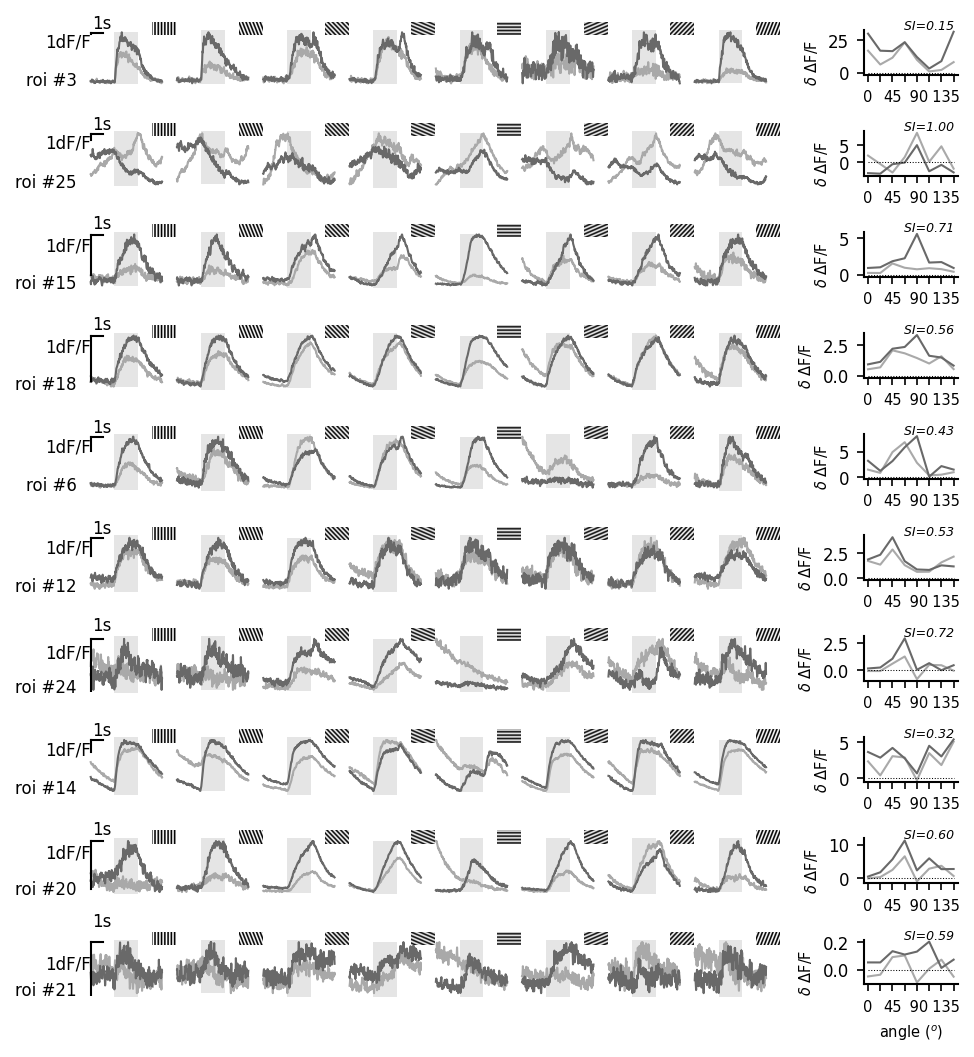

In [288]:
import sys, os
import numpy as np
import matplotlib.pylab as plt
sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data, scan_folder_for_NWBfiles
from physion.analysis.process_NWB import EpisodeData
from physion.utils import plot_tools as pt
from physion.dataviz.episodes.trial_average import plot_trial_average
sys.path.append('../')
import plot_tools as pt

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

def selectivity_index(angles, resp):
    """
    computes the selectivity index: (Pref-Orth)/(Pref+Orth)
    clipped in [0,1]
    """
    imax = np.argmax(resp)
    iop = np.argmin(((angles[imax]+90)%(180)-angles)**2)
    if (resp[imax]>0):
        return min([1,max([0,(resp[imax]-resp[iop])/(resp[imax]+resp[iop])])])
    else:
        return 0

def cell_tuning_example_fig(filename,
                            contrasts=[1.0],
                            colors=['darkgrey', 'dimgrey'],
                            stat_test_props = dict(interval_pre=[-1,0], 
                                                   interval_post=[1,2],
                                                   test='ttest',
                                                   positive=True),
                            response_significance_threshold = 0.01,
                            Nsamples = 10, # how many cells we show
                            seed=10):
    
    
    data = Data(filename)
    
    EPISODES = EpisodeData(data,
                           quantities=['dFoF'],
                           protocol_id=np.flatnonzero(['8orientation' in p for p in data.protocols]),
                           with_visual_stim=True,
                           verbose=True)
    
    fig, AX = pt.plt.subplots(Nsamples, len(EPISODES.varied_parameters['angle']), 
                          figsize=(7,7*Nsamples/10))
    plt.subplots_adjust(right=0.75, left=0.1, top=0.97, bottom=0.05, wspace=0.1, hspace=0.8)
    
    for Ax in AX:
        for ax in Ax:
            ax.axis('off')

    np.random.seed(seed)
    for i, r in enumerate(np.random.choice(np.arange(data.vNrois), 
                                           min([Nsamples, data.vNrois]), replace=False)):

        # SHOW trial-average
        plot_trial_average(EPISODES,
                           condition=(EPISODES.contrast==contrasts[0]) if len(contrasts)==1 else None,
                           column_key='angle',
                           color_key='contrast' if len(contrasts)>1 else '',
                           color=colors[0] if len(contrasts)==1 else colors,
                           quantity='dFoF',
                           ybar=1., ybarlabel='1dF/F',
                           xbar=1., xbarlabel='1s',
                           roiIndex=r,
                           with_stat_test=(len(contrasts)==1),
                           stat_test_props=stat_test_props,
                           with_screen_inset=True,
                           with_std=(len(contrasts)==1),
                           AX=[AX[i]], no_set=False)
        AX[i][0].annotate('roi #%i  ' % (r+1), (0,0), ha='right', xycoords='axes fraction')

        # SHOW summary angle dependence
        inset = pt.inset(AX[i][-1], (2.2, 0.2, 1.2, 0.8))

        for contrast, color in zip(contrasts, colors):
            
            angles, y, sy, responsive_angles = [], [], [], []
            responsive = False

            for a, angle in enumerate(EPISODES.varied_parameters['angle']):

                stats = EPISODES.stat_test_for_evoked_responses(episode_cond=\
                                                EPISODES.find_episode_cond(key=['angle', 'contrast'],
                                                                           value=[angle, contrast]),
                                                                response_args=dict(quantity='dFoF', roiIndex=r),
                                                                **stat_test_props)

                angles.append(angle)
                y.append(np.mean(stats.y-stats.x))    # means "post-pre"
                sy.append(np.std(stats.y-stats.x))    # std "post-pre"

                if stats.significant(threshold=response_significance_threshold):
                    responsive = True
                    responsive_angles.append(angle)

            pt.plot(angles, np.array(y), sy=np.array(sy) if len(contrasts)==1 else None,
                    color=color, ax=inset, no_set=True)
        inset.plot(angles, 0*np.array(angles), 'k:', lw=0.5)
        inset.set_ylabel('$\delta$ $\Delta$F/F     ', fontsize=7)
        inset.set_xticks(angles)
        #inset.set_xticklabels(['%i'%a if (i%2==0) else '' for i, a in enumerate(angles)], fontsize=7)
        inset.set_xticklabels(['0','','45','', ' 90', '', '  135', ''], fontsize=7)
        if i==(Nsamples-1):
            inset.set_xlabel('angle ($^{o}$)', fontsize=7)

        SI = selectivity_index(angles, y)
        inset.annotate('SI=%.2f ' % SI, (1, 1), ha='right', style='italic', fontsize=6,
                       color=('k' if responsive else 'lightgray'), xycoords='axes fraction')
        
    return fig

fig = cell_tuning_example_fig(SUMMARY['WT']['FILES'][10], seed=0,
                              contrasts=[0.5,1])
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))

NWB-file reading time: 151.9ms
  Number of episodes over the whole recording: 160/163 (with protocol condition)
  building episodes with 1 modalities [...]

calculating dF/F with method "maximin" [...]

  ** all ROIs passed the positive F0 criterion ** 

-> dFoF calculus done !  (calculation took 0.0s)
0.1432391503683066
  -> [ok] episodes ready !


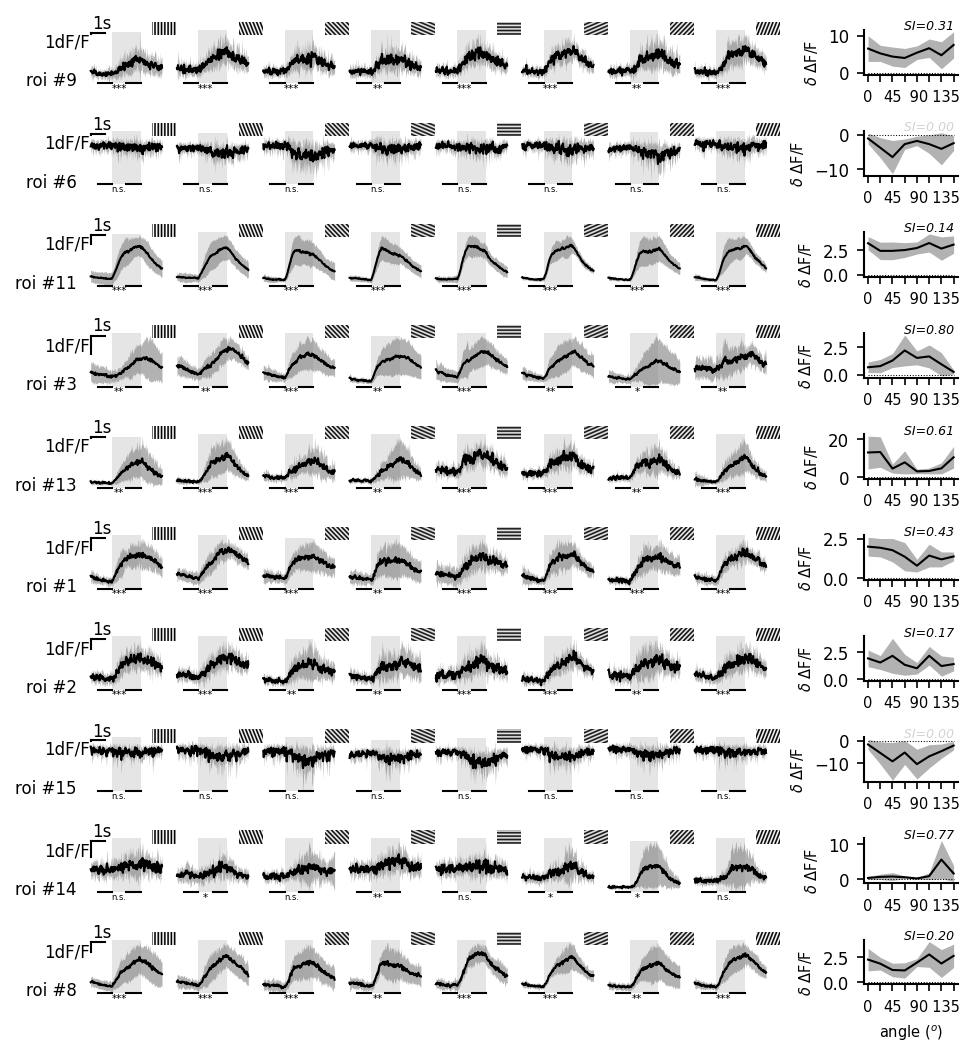

In [53]:
fig = cell_tuning_example_fig(SUMMARY['WT']['FILES'][1], seed=7, Nsamples=10,
                              contrasts=[1], colors=['k'])
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))

In [30]:
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))

No handles with labels found to put in legend.


1 0.7996838878769947
5 1.1843100377741265
1 1.051085373700386
5 1.3873206414240624


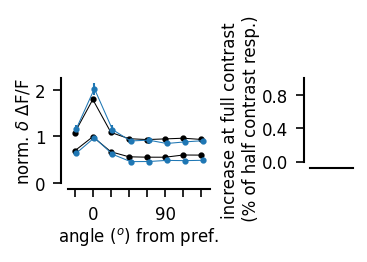

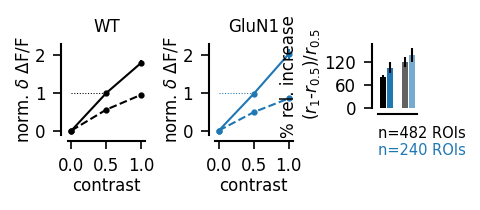

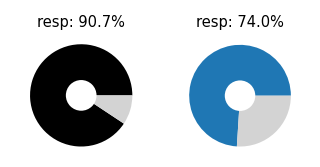

In [276]:
dFoF_inclusion_cond = 0.1
MAX_EVOKED = 20

def generate_comparison_figs(SUMMARY, 
                             cases=['WT'],
                             average_by='ROIs',
                             colors=['k', 'tab:blue', 'tab:green'],
                             norm='',
                             ms=2):
    
    fig, ax = plt.subplots(1, figsize=(2, 1))
    plt.subplots_adjust(top=0.9, bottom=0.2, right=0.6)
    inset = pt.inset(ax, (1.7, 0.2, 0.3, 0.8))

    fig2, AX = plt.subplots(1, 2, figsize=(4,0.8))
    plt.subplots_adjust(wspace=0.9, right=0.5)
    inset2 = pt.inset(AX[1], [2.1, 0.3, 0.5, 0.7])
    
    fig3, AX3 = plt.subplots(1,2,figsize=(2.5,1))
    
    shifted_angle = SUMMARY[cases[0]]['RESPONSES'][0]['shifted_angle']
    
    AX[0].legend(frameon=False, loc=(1,1))

    for i, case in enumerate(cases):

        frac = 100*np.mean([r['frac_responsive'] for r in SUMMARY[case]['RESPONSES']])
        pt.pie([frac, 100-frac], ax=AX3[i], COLORS=[colors[i], 'lightgrey'])
        AX3[i].set_title('resp: %.1f%%' % frac, fontsize=7)
        
        resp = {}
        for key in ['resp_c=0.5', 'resp_c=1.0']:
            resp[key] = []
        for rSession in SUMMARY[case]['RESPONSES']:
            # loop over sessions
            rS05, rS10 = [], []
            for r05, r10 in zip(rSession['resp_c=0.5'], rSession['resp_c=1.0']):
                # loop over rois
                if np.max(r05)<MAX_EVOKED and (np.max(r10)<MAX_EVOKED): # TRESHOLD MAX
                    rS05.append(list(np.clip(r05, dFoF_inclusion_cond, np.inf))) # + CLIP
                    rS10.append(list(np.clip(r10, dFoF_inclusion_cond, np.inf))) # + CLIP
            if average_by=='sessions':
                for key, rS in zip(['resp_c=0.5', 'resp_c=1.0'], [rS05, rS10]):
                    resp[key].append(list(np.mean(rS, axis=0)))
            else:
                for key, rS in zip(['resp_c=0.5', 'resp_c=1.0'], [rS05, rS10]):
                    resp[key] += rS
        for key in ['resp_c=0.5', 'resp_c=1.0']:
            resp[key] = np.array(resp[key])
            
        # NORMALIZATION
        included = resp['resp_c=0.5'][:,1]>dFoF_inclusion_cond
        norm_factor = resp['resp_c=0.5'][included,1] # pref. @ contrast = 0.5
        
        for key, alpha in zip(['resp_c=0.5', 'resp_c=1.0'], [0.5, 1]):
            
            resp[key] = resp[key][included,:]
            resp[key] = np.clip(resp[key], 0, 8)
            
            resp[key] = np.divide(resp[key].T, norm_factor).T

            pt.scatter(shifted_angle+2*i, np.mean(resp[key], axis=0),
                       sy=stats.sem(resp[key], axis=0), ax=ax, color=colors[i],
                       ms=ms, lw=0.5, alpha=alpha)
            
        #inset.bar([i], [100*(np.mean(resp['resp_c=1.0'],axis=0)[1]-1)], 
        #          yerr=[100*stats.sem(resp['resp_c=1.0'],axis=0)[1]], color=colors[i])
        
        for index in [1,5]:
            x, y = [0 ,0.5, 1], [0,np.mean(resp['resp_c=0.5'][:, index]), np.mean(resp['resp_c=1.0'][:, index])]
            sy = [0,stats.sem(resp['resp_c=0.5'][:, index]),stats.sem(resp['resp_c=1.0'][:, index])]
            AX[i].plot(x, y, '-' if index==1 else '--', color=colors[i], label='pref.' if index==1 else 'orth.')
            pt.scatter(x, y, sy=sy, ax=AX[i], color=colors[i], ms=ms)
            
            rel_increase = (resp['resp_c=1.0'][:,index]-resp['resp_c=0.5'][:,index])/resp['resp_c=0.5'][:,index]
            inset2.bar([i+3*(index-1)/4], [100*np.mean(rel_increase)],
                       yerr=[100*stats.sem(rel_increase)], color=colors[i], alpha=1/index**0.3)
            
        AX[i].plot([0,0.5], [1,1], 'k:', lw=0.5, color=colors[i])
        pt.set_plot(AX[i], xlabel='contrast', title=case, 
                    yticks=[0,1,2],
                    xticks=[0,0.5,1], ylabel='norm. $\delta$ $\Delta$F/F')

        inset2.annotate(i*'\n'+'\nn=%i %s' % (len(resp[key]), average_by),
                       (0,0), fontsize=7,
                       va='top',color=colors[i], xycoords='axes fraction')
            
    pt.set_common_ylims(AX)
    pt.set_plot(inset, xticks=[], ylabel='increase at full contrast\n (% of half contrast resp.)')
    pt.set_plot(inset2, xticks=[], ylabel='% rel. increase\n ($r_{1}$-$r_{0.5}$)/$r_{0.5}$')

    ylabel=norm+'$\delta$ %s' % SUMMARY['quantity'].replace('dFoF', '$\Delta$F/F')
    pt.set_plot(ax, xlabel='angle ($^o$) from pref.',
                ylabel=ylabel,
                yticks=[0,1,2],
                xticks=shifted_angle,
                xticks_labels=['%.0f'%s if (i%4==1) else '' for i,s in enumerate(shifted_angle)])

    
    return fig, fig2, fig3

SUMMARY = np.load('../data/dFoF-contrast-dep-ff-gratings.npy', allow_pickle=True).item()
FIGS = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'], average_by='ROIs', norm='norm. ')
FIGS[1].savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '1.svg'))
FIGS[2].savefig(os.path.join(os.path.expanduser('~'), 'Desktop', 'poster-material', '2.svg'))

In [190]:
SUMMARY['WT']['RESPONSES'][0].keys()

dict_keys(['roi', 'resp_c=0.5', 'resp_c=1.0', 'shifted_angle', 'frac_responsive'])

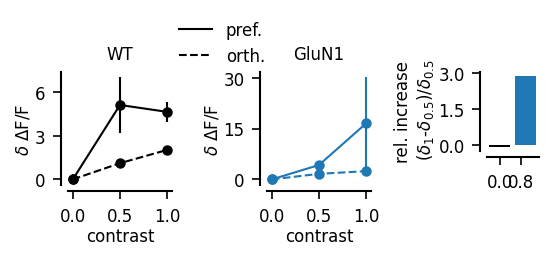

In [141]:
fig, AX = plt.subplots(1, 2, figsize=(3,1))
plt.subplots_adjust(wspace=0.9, right=0.8)
inset = pt.inset(AX[1], [2.1, 0.3, 0.5, 0.7])
for k, key, c, ax in zip(range(2), ['WT', 'GluN1'], ['k', 'tab:blue'], AX):
    resp_c05 = np.concatenate([r['resp_c=0.5'] for r in SUMMARY[key]['RESPONSES']])
    resp_c1 = np.concatenate([r['resp_c=1.0'] for r in SUMMARY[key]['RESPONSES']])
    for index in [1,5]:
        x, y = [0 ,0.5, 1], [0,np.mean(resp_c05[:, index]), np.mean(resp_c1[:, index])]
        sy = [0,stats.sem(resp_c05[:, index]),stats.sem(resp_c1[:, index])]
        ax.plot(x, y, '-' if index==1 else '--', color=c, label='pref.' if index==1 else 'orth.')
        pt.scatter(x, y, sy=sy, ax=ax, color=c)
        if index==1:
            rel_increase = (np.mean(resp_c1[:,index])-np.mean(resp_c05[:,index]))/np.mean(resp_c05[:,index])
            inset.bar([k], [np.mean(rel_increase)], color=c, alpha=1/index)
    pt.set_plot(ax, xlabel='contrast', title=key, xticks=[0,0.5,1], ylabel='$\delta$ $\Delta$F/F')
pt.set_plot(inset, ylabel='rel. increase\n ($\delta_{1}$-$\delta_{0.5}$)/$\delta_{0.5}$')
AX[0].legend(frameon=False, loc=(1,1))

NameError: name 'cases' is not defined

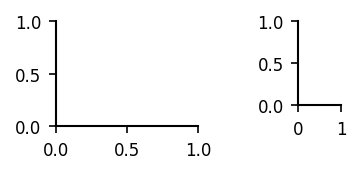

In [102]:
fig, ax = plt.subplots(1, figsize=(2, 1))
plt.subplots_adjust(top=0.9, bottom=0.2, right=0.6)
inset = pt.inset(ax, (1.7, 0.2, 0.3, 0.8))

shifted_angle = SUMMARY[cases[0]]['RESPONSES'][0]['shifted_angle']



for i, case in enumerate(cases):

    resp = {}
    for key in ['resp_c=0.5', 'resp_c=1.0']:

        if average_by=='sessions':
            resp[key] = np.array([np.mean(r[key], axis=0) for r in SUMMARY[case]['RESPONSES']])
        else:
            resp[key] = np.concatenate([r[key] for r in SUMMARY[key]['RESPONSES']])

        resp[key] = np.clip(resp[key], 0, 10) # CLIP RESPONSIVE TO POSITIVE VALUES

    norm_factor = np.mean(resp['resp_c=0.5'],axis=0)[1] # pref. @ contrast = 0.5

    for key, alpha in zip(['resp_c=0.5', 'resp_c=1.0'], [0.5, 1]):

        resp[key] /= norm_factor

        pt.scatter(shifted_angle+2*i, np.mean(resp[key], axis=0),
                   sy=stats.sem(resp[key], axis=0), ax=ax, color=colors[i],
                   ms=ms, lw=0.5, alpha=alpha)

    #inset.bar([i], [np.mean(resp['resp_c=1.0'],axis=0)[1]], color=colors[i])

    try:
        if average_by=='sessions':
            inset.annotate(i*'\n'+'\nN=%i %s (%i ROIs, %i mice)' % (len(resp),
                                                average_by, np.sum([len(r) for r in SUMMARY[key]['RESPONSES']]),
                                                len(np.unique(SUMMARY[key]['subjects']))),
                           (0,0), fontsize=7,
                           va='top',color=colors[i], xycoords='axes fraction')
        else:
            inset.annotate(i*'\n'+'\nn=%i %s (%i sessions, %i mice)' % (len(resp),
                                                average_by, len(SUMMARY[key]['RESPONSES']),
                                                                len(np.unique(SUMMARY[key]['subjects']))),
                           (0,0), fontsize=7,
                           va='top',color=colors[i], xycoords='axes fraction')
    except BaseException as be:
        pass

#pt.set_plot(inset, xticks=[], ylabel='select. index', yticks=[0, 0.5, 1], ylim=[0, 1.09])

ylabel=norm+'$\delta$ %s' % SUMMARY['quantity'].replace('dFoF', '$\Delta$F/F')
pt.set_plot(ax, xlabel='angle ($^o$) from pref.',
            ylabel=ylabel,
            #yticks=[0.4,0.6,0.8,1],
            xticks=shifted_angle,
            xticks_labels=['%.0f'%s if (i%4==1) else '' for i,s in enumerate(shifted_angle)])

return fig, ax

SUMMARY = np.load('../data/dFoF-contrast-dep-ff-gratings.npy', allow_pickle=True).item()
fig, ax = generate_comparison_figs(SUMMARY, ['WT', 'GluN1'], average_by='sessions', norm='norm. ')

In [60]:
SUMMARY = np.load('../data/dFoF-contrast-dep-ff-gratings.npy', allow_pickle=True).item()

SUMMARY

{'WT': {'FILES': ['/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_15-13-30-47.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_15-14-05-01.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_15-15-10-04.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_15-15-48-06.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_17-15-30-46.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_17-16-15-09.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_17-17-02-46.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_02_17-17-39-12.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_03_28-12-31-50.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_03_31-12-55-47.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_04_19-12-03-19.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT-NR1-GluN3-2023/2023_04_21-17-01-03.nwb',
   '/home/yann.zerlaut/CURATED/SST-WT